In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [3]:
ls Dental_dataset/

 Adult_tooth_segmentation_dataset/               'Pediatric dental disease detection dataset'/
'Childrens dental caries segmentation dataset'/


In [4]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array
import pathlib
from os import listdir
import natsort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [5]:
epochs = 7000
batch = 16
eta = 0.001
weight_decay = 6e-8
imageShape = (224, 224, 1)
maskShape = (224, 224, 1)


In [6]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
    def readPathes(self,):
      self.images = []
      self.masks = []
      image_list = listdir(self.imagesPathes)
      masks_list = listdir(self.masksPathes)
      for image in image_list:
        self.images.append(f"{self.imagesPathes}/{image}")
      for mask in masks_list:
        self.masks.append(f"{self.masksPathes}/{mask}")
      self.images = natsort.natsorted(self.images)
      self.masks = natsort.natsorted(self.masks)
    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, (224, 224))
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
          for aug in range(2):
            imageup = image
            maskup = mask
            if aug == 0:
              imageup = image
              maskup = mask
            else:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

In [7]:
datasetObject = readDataset('Dental_dataset/Adult_tooth_segmentation_dataset/Panoramic_radiography_database/images/',
                            'Dental_dataset/Adult_tooth_segmentation_dataset/Panoramic_radiography_database/mask/')
datasetObject.readPathes()


In [8]:
len(datasetObject.images), len(datasetObject.masks)

(598, 598)

In [9]:
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')

In [10]:
images.shape, masks.shape

((598, 224, 224), (598, 224, 224))

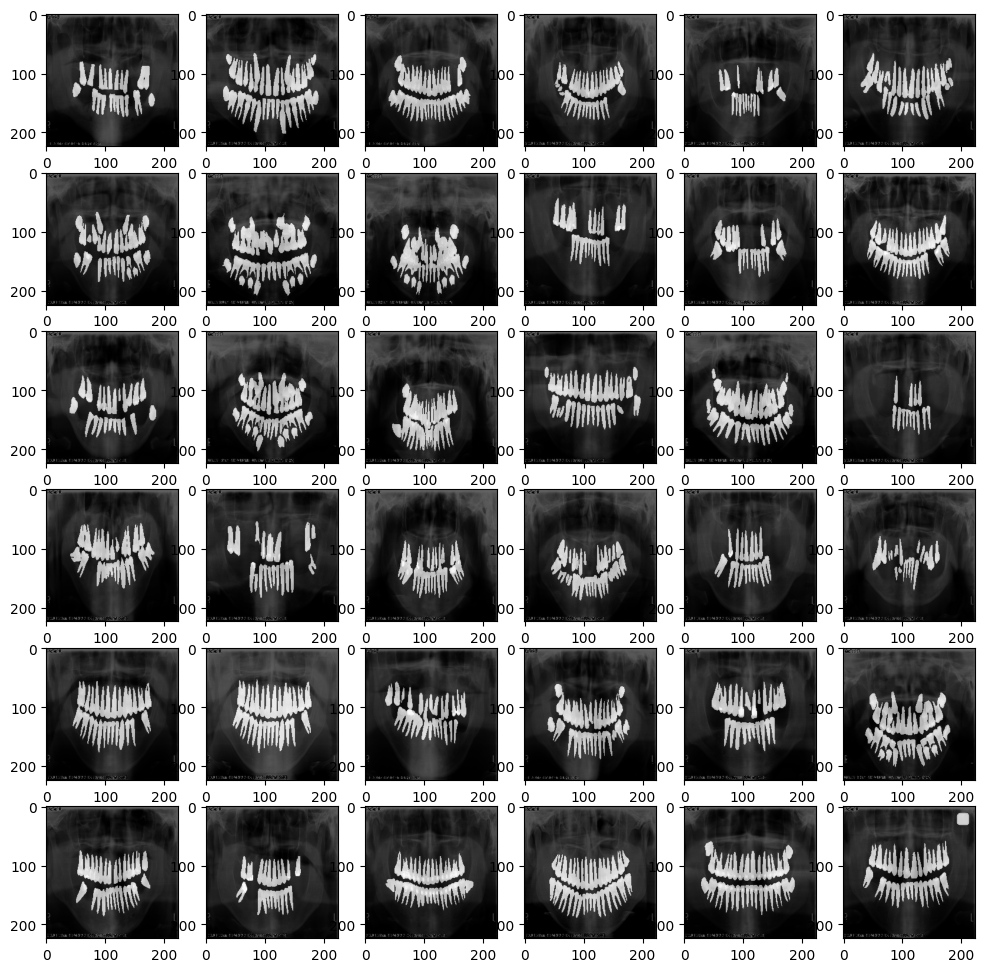

In [11]:
plt.figure(figsize = (12, 12))
for i in range(36):
    plt.subplot(6, 6, (i + 1))
    plt.imshow(images[i], cmap = 'gray')
    plt.imshow(masks[i], alpha = 0.6, cmap = 'gray')
plt.legend()

In [12]:
np.unique(masks), np.min(masks), np.max(masks), np.min(images), np.max(images)

(array([0, 1]), 0, 1, 0.0, 1.0)

In [13]:
x = layers.Input(shape = (224, 224, 1))
y = layers.Input(shape = (224, 224, 1))
z = layers.multiply([x, y])
m = models.Model(inputs = [x, y], outputs = z)
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply (Multiply)         (None, 224, 224, 1)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte

In [14]:
imagesByMasks = m([images[:64], masks[:64]])
imagesByMasks.shape

TensorShape([64, 224, 224, 1])

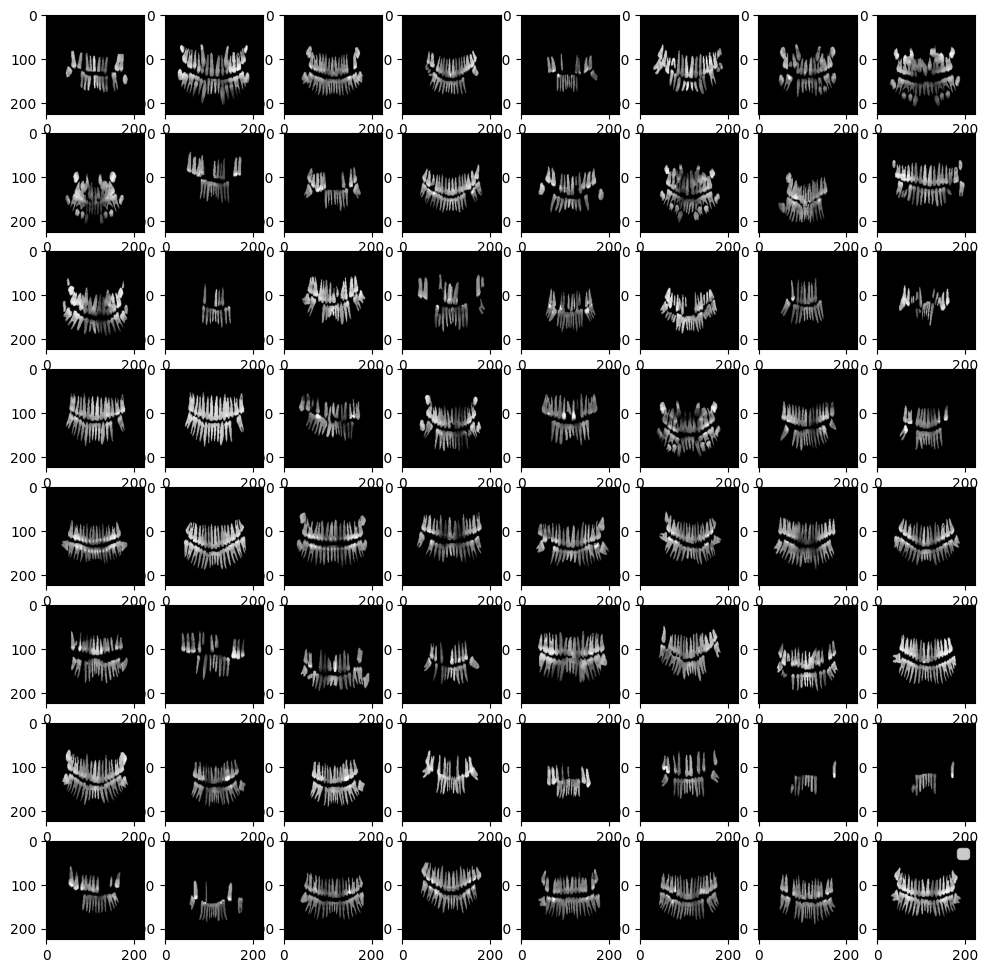

In [15]:
plt.figure(figsize = (12, 12))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesByMasks[i], cmap = 'gray')
plt.legend()

In [16]:
i = 80
validImages = images[:i]
validMasks = masks[:i]
trainImages = images[i:]
trainMasks = masks[i:]
validImages.shape, validMasks.shape, trainImages.shape, trainMasks.shape

((80, 224, 224), (80, 224, 224), (518, 224, 224), (518, 224, 224))

In [17]:
def convolution(inputs, filter, padding, strides, kernel, activation, conv_type):
  x = inputs
  x = layers.Conv2D(filter, kernel_size = kernel, padding = padding,
                    strides = strides)(x)
  x = layers.GroupNormalization(groups = filter)(x)
  if conv_type == 'decoder':
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter*2, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter*2)(x)
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter)(x)
  x = layers.average([x, layers.Conv2D(filter, kernel_size = 1, padding = 'same',
                                      strides = 1)(inputs)])
  x = layers.Activation(activation)(x)
  return x

In [18]:
def encoder(input, filter, padding, strides, kernel, activation):
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, 'encoder')
  downsample = layers.AveragePooling2D()(x)
  return downsample, x

In [19]:
def decoder(input, filter, skip, padding, strides, kernel, activation):
  x = input
  x = layers.Conv2DTranspose(filter, kernel_size = kernel, padding = padding,
                             strides = 2, activation = activation)(x)
  x = layers.average([x, skip])
  x = convolution(x, filter, padding, strides, kernel, activation, 'decoder')
  return x

In [20]:
def generator(input, filter, padding, strides, kernel, weights):
  x = input
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  deco = decoder(con5, filter*16, skip5, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco1 = decoder(deco, filter*8, skip4, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco2 = decoder(deco1, filter*4, skip3, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco3 = decoder(deco2, filter*2, skip2, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco4 = decoder(deco3, filter, skip1, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  output = layers.Conv2DTranspose(1, kernel_size = kernel, strides = strides,
                                  padding = padding, activation = 'sigmoid')(deco4)
  generator = models.Model(inputs = input, outputs = output, name = 'generator')
  if weights != None:
    generator.load_weights('/kaggle/working/mask_generator.h5')
  generator.summary()
  return generator

In [21]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = None)


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         320       ['input_3[0][0]']             
                                                                                                  
 group_normalization (Group  (None, 224, 224, 32)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         64        ['input_3[0][0]']     

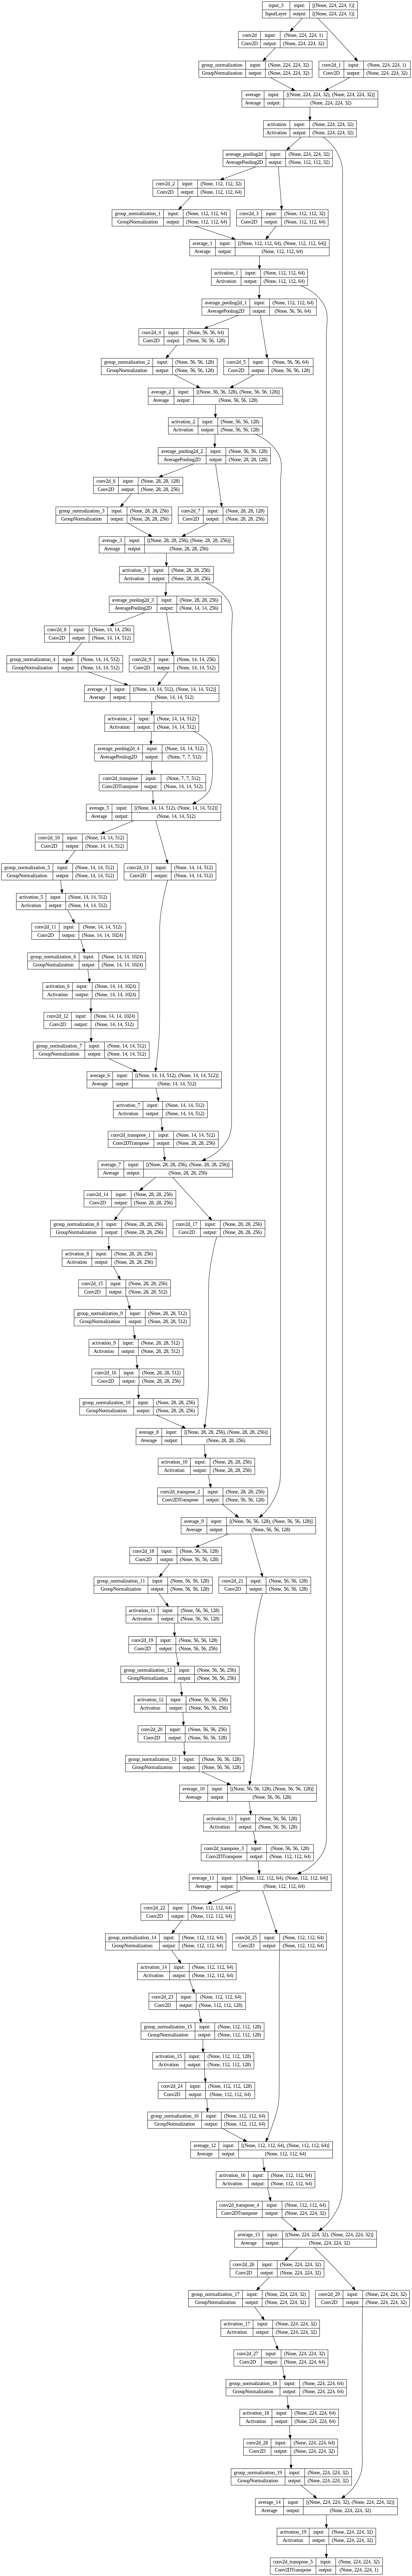

In [22]:
tf.keras.utils.plot_model(G, show_shapes = True)

In [23]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, weights,
                  lossFn, learning_rate, weight_decay):
  x = layers.multiply([ImageInput, maskInput])
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  x = layers.GlobalAveragePooling2D()(con5)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(1)(x)
  discriminator = models.Model(inputs = [maskInput, ImageInput], outputs = x,
                              name = 'discriminator')
  if weights != None:
    discriminator.load_weights('/kaggle/working/discriminator.h5')
  discriminator.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                                              weight_decay = weight_decay))
  discriminator.summary()
  return discriminator

In [24]:
D = discriminator(ImageInput = layers.Input(shape = imageShape), maskInput = layers.Input(shape = maskShape),
                  filter = 32, padding = 'same', strides = 1, kernel = 3, weights = None,
                  lossFn = 'mse', learning_rate = eta, weight_decay = weight_decay)


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply_1 (Multiply)       (None, 224, 224, 1)          0         ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 224, 224, 32)         320       ['multiply_1[0][0]

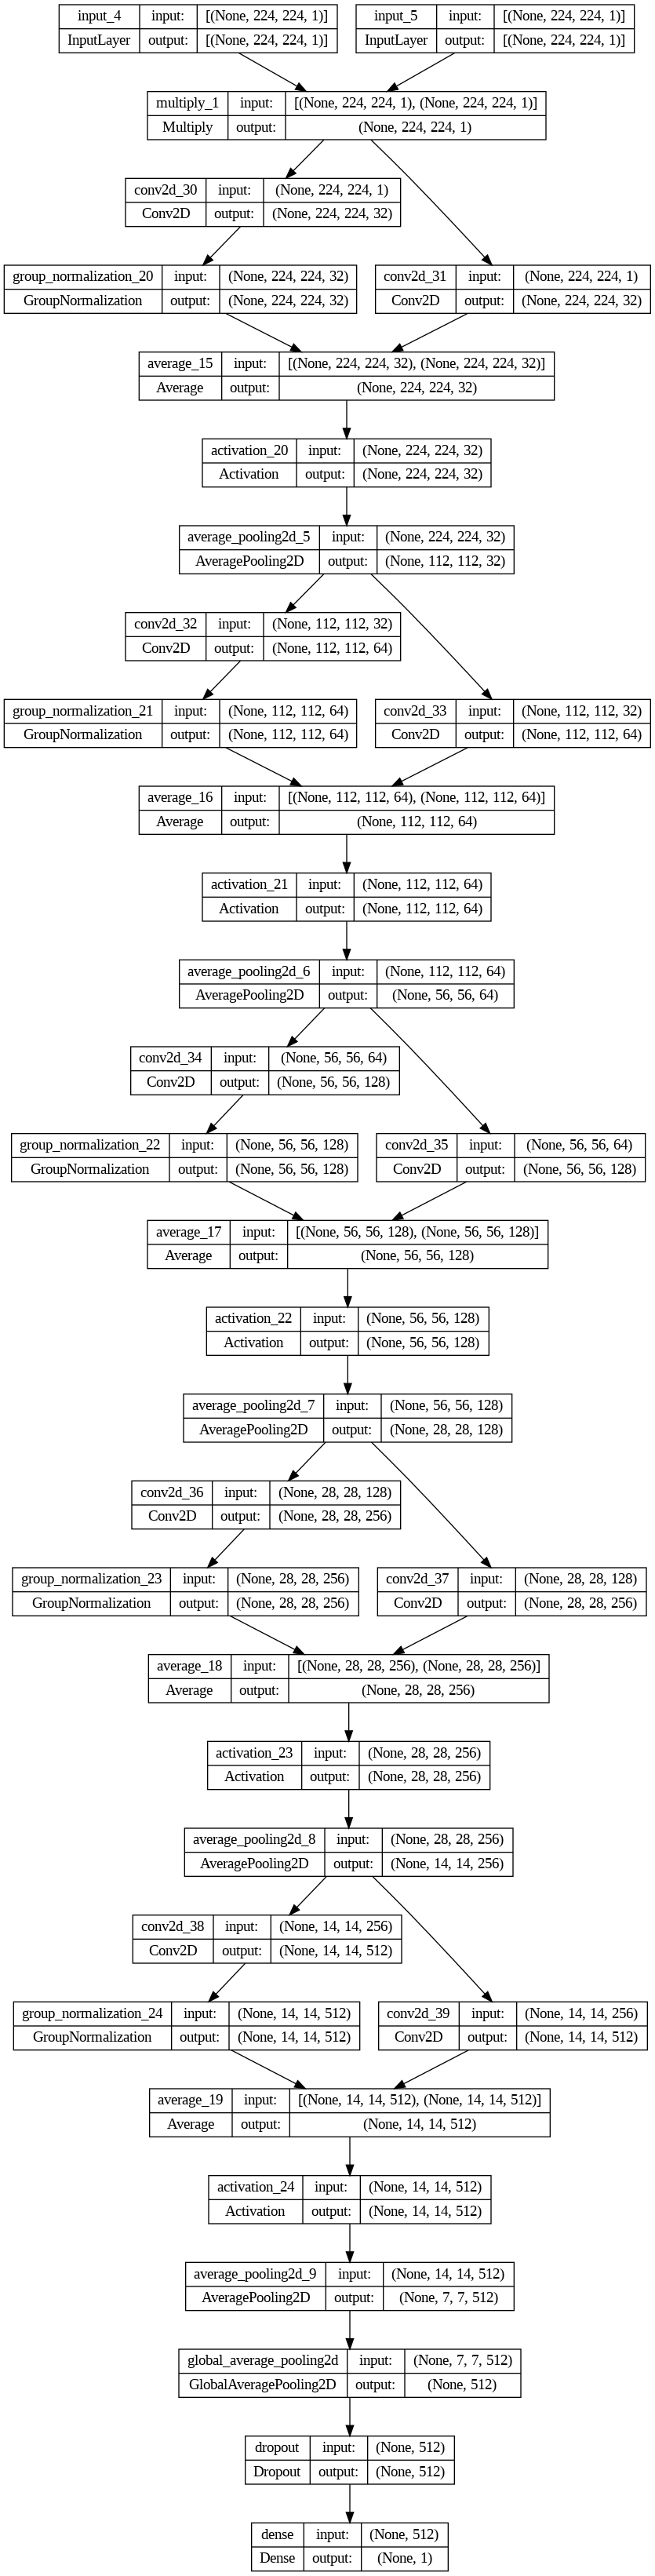

In [25]:
tf.keras.utils.plot_model(D, show_shapes = True)

In [26]:
def GAN(discriminator, generator, imageInput, maskInput, learning_rate, weight_decay,
                   lossFn):
  discriminator.trainable = False
  gan = models.Model(
      inputs = [imageInput],
      outputs = discriminator([generator(imageInput), imageInput],),
      name = 'gan'
  )
  gan.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate*0.5,
                                                                              weight_decay = weight_decay*0.5))
  gan.summary()
  return gan

In [27]:
gan = GAN(discriminator = D, generator = G, imageInput = layers.Input(shape = imageShape),
          maskInput = layers.Input(shape = maskShape), learning_rate = eta, weight_decay = weight_decay,
                   lossFn = 'mse')

Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 224, 224, 1)          2174774   ['input_6[0][0]']             
                                                          5                                       
                                                                                                  
 discriminator (Functional)  (None, 1)                    1745601   ['generator[0][0]',           
                                                                     'input_6[0][0]']             
                                                                                                

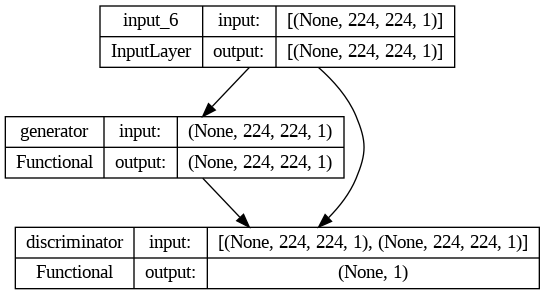

In [28]:
tf.keras.utils.plot_model(gan, show_shapes = True)

In [29]:
def samples(generator, images, realMasks):
  masks = tf.squeeze(generator.predict(images))
  all = np.vstack([realMasks, masks])
  plt.figure(figsize = (12, 4))
  for i in range(16):
    plt.subplot(2, 8, (i + 1))
    plt.imshow(all[i], cmap = 'gray')
  plt.show()

Epoch/Epochs: 0/7000
discriminator loss: [tag: 0.9916712045669556,], generator loss: [tag: 0.019115030765533447,]
1/1 [==============================] - 7s 7s/step


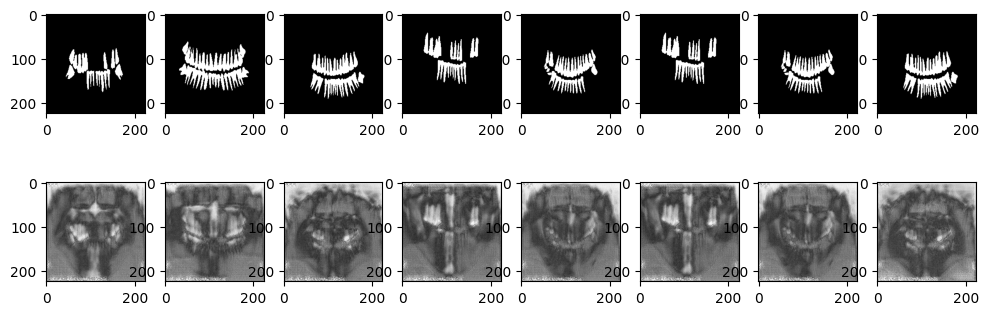

Epoch/Epochs: 50/7000
discriminator loss: [tag: 0.2906373143196106,], generator loss: [tag: 0.2021719515323639,]
1/1 [==============================] - 0s 26ms/step


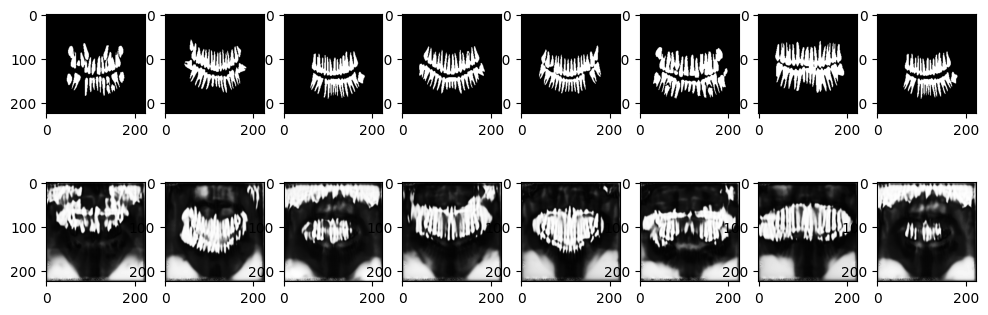

Epoch/Epochs: 100/7000
discriminator loss: [tag: 0.08460040390491486,], generator loss: [tag: 0.6156827211380005,]
1/1 [==============================] - 0s 26ms/step


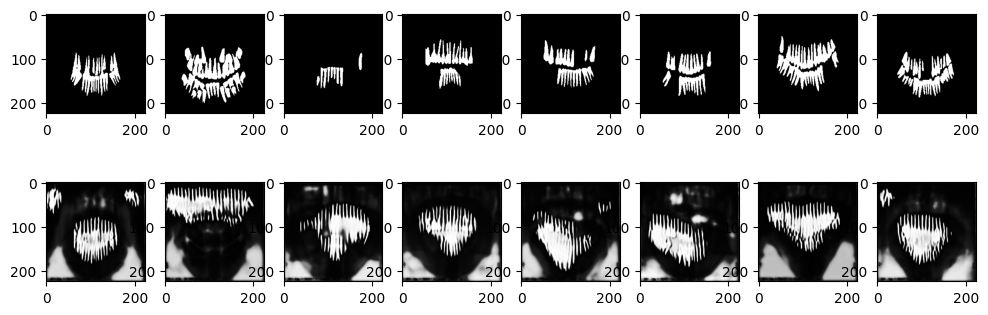

Epoch/Epochs: 150/7000
discriminator loss: [tag: 0.11072445660829544,], generator loss: [tag: 0.32201775908470154,]
1/1 [==============================] - 0s 27ms/step


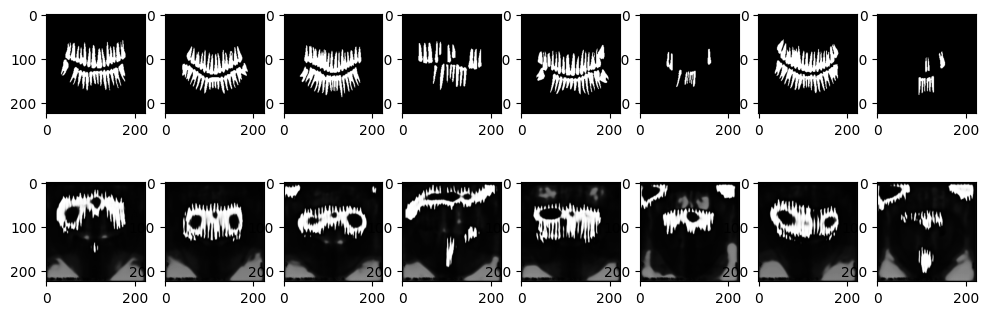

Epoch/Epochs: 200/7000
discriminator loss: [tag: 0.15642158687114716,], generator loss: [tag: 0.15072259306907654,]
1/1 [==============================] - 0s 24ms/step


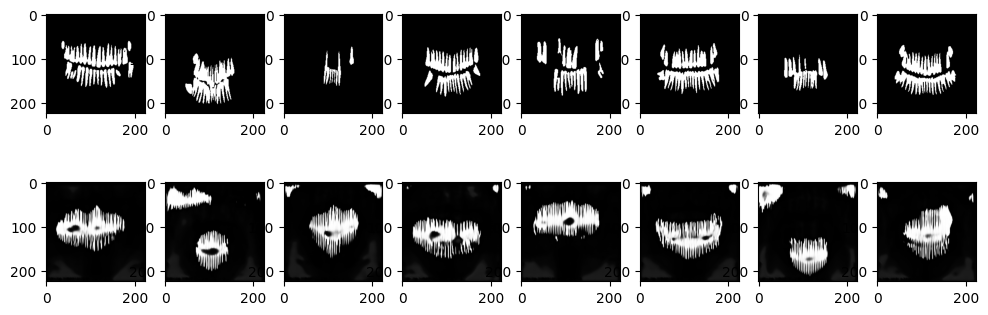

Epoch/Epochs: 250/7000
discriminator loss: [tag: 0.2644447982311249,], generator loss: [tag: 1.2236335277557373,]
1/1 [==============================] - 0s 27ms/step


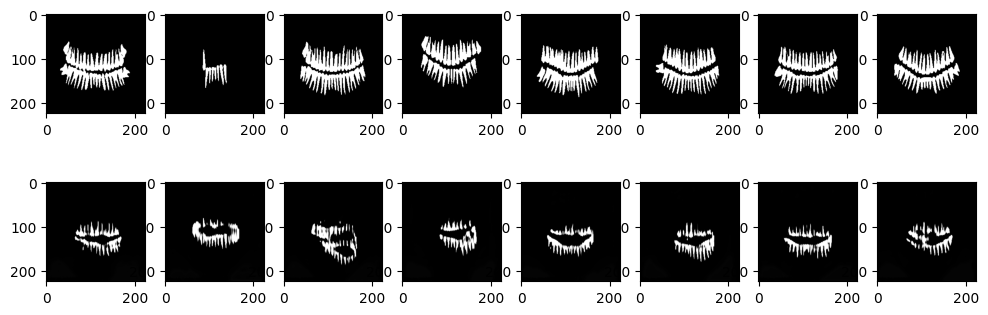

Epoch/Epochs: 300/7000
discriminator loss: [tag: 0.2623123824596405,], generator loss: [tag: 0.4314374327659607,]
1/1 [==============================] - 0s 27ms/step


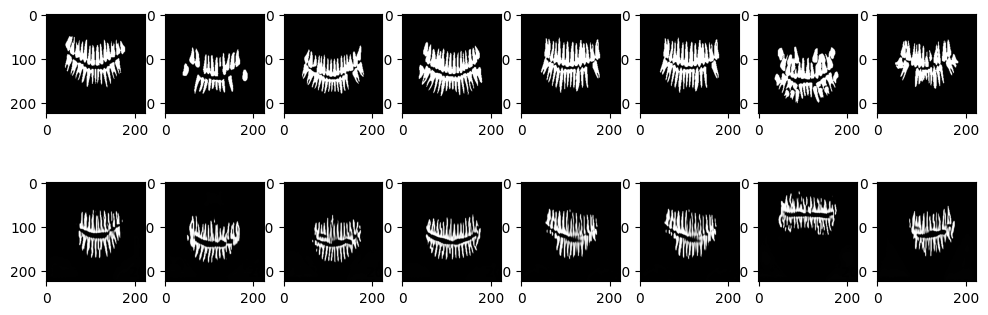

Epoch/Epochs: 350/7000
discriminator loss: [tag: 0.29830411076545715,], generator loss: [tag: 0.23031724989414215,]
1/1 [==============================] - 0s 40ms/step


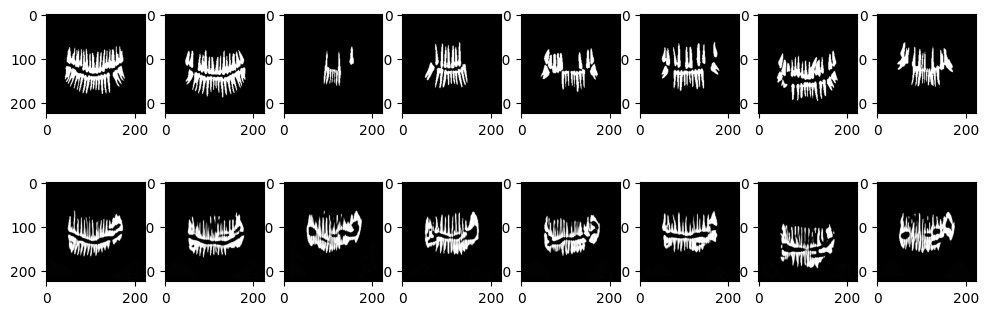

Epoch/Epochs: 400/7000
discriminator loss: [tag: 0.24749720096588135,], generator loss: [tag: 0.2585294544696808,]
1/1 [==============================] - 0s 48ms/step


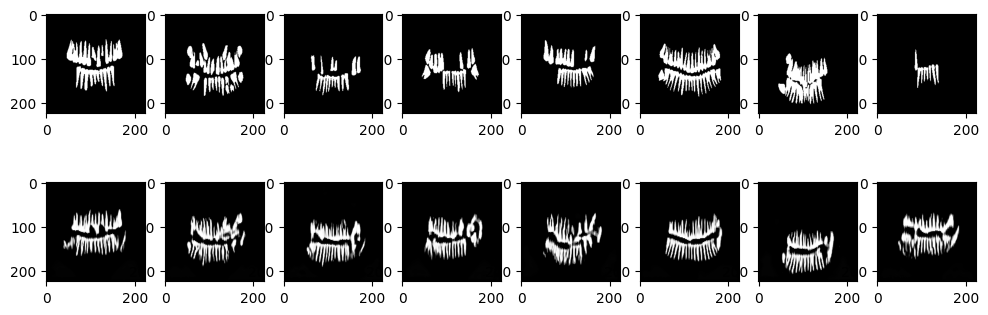

Epoch/Epochs: 450/7000
discriminator loss: [tag: 0.22413933277130127,], generator loss: [tag: 0.2424755096435547,]
1/1 [==============================] - 0s 25ms/step


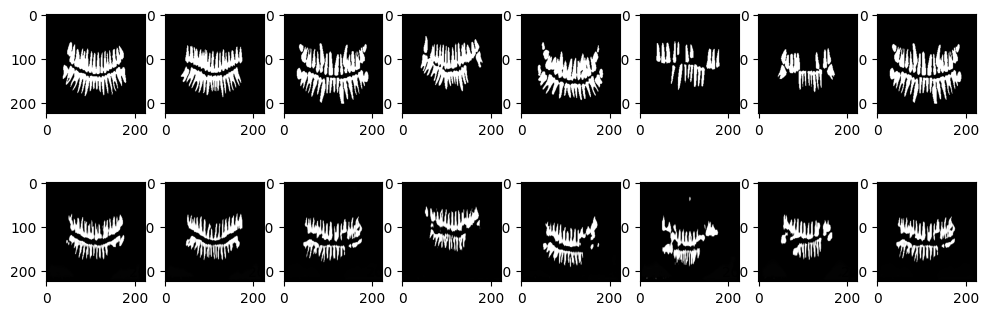

Epoch/Epochs: 500/7000
discriminator loss: [tag: 0.22452878952026367,], generator loss: [tag: 0.41361868381500244,]
1/1 [==============================] - 0s 26ms/step


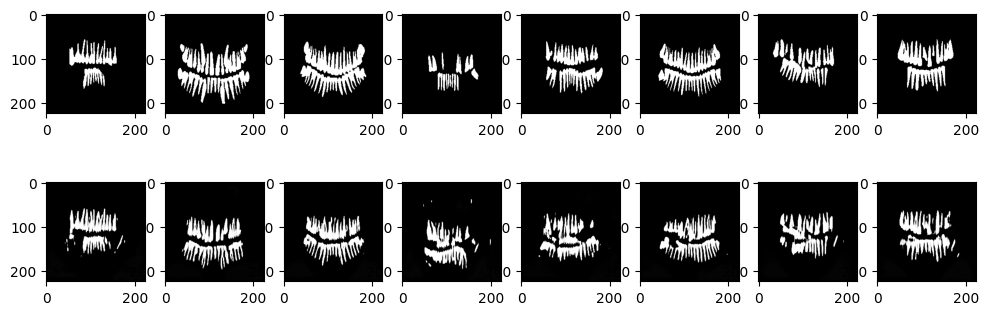

Epoch/Epochs: 550/7000
discriminator loss: [tag: 0.1994592249393463,], generator loss: [tag: 0.3770579993724823,]
1/1 [==============================] - 0s 26ms/step


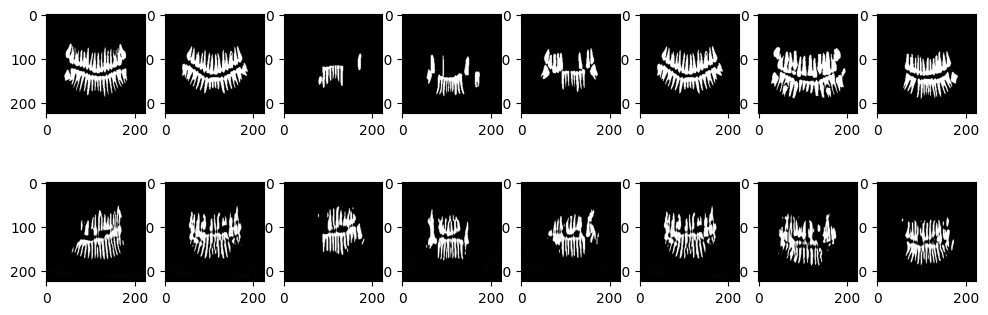

Epoch/Epochs: 600/7000
discriminator loss: [tag: 0.25127288699150085,], generator loss: [tag: 0.3722347915172577,]
1/1 [==============================] - 0s 25ms/step


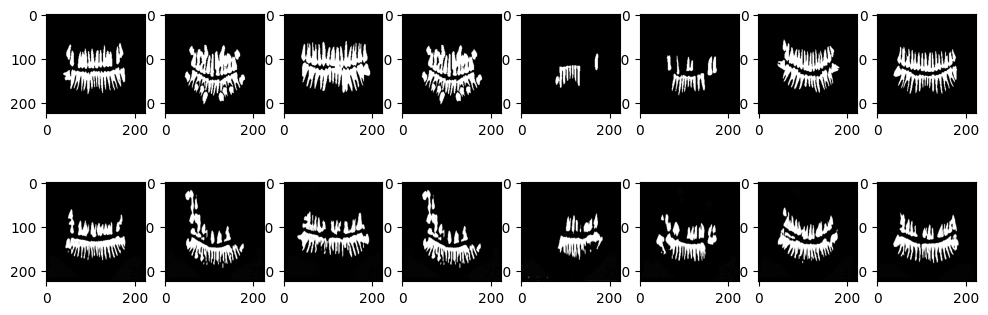

Epoch/Epochs: 650/7000
discriminator loss: [tag: 0.23506218194961548,], generator loss: [tag: 0.11115555465221405,]
1/1 [==============================] - 0s 35ms/step


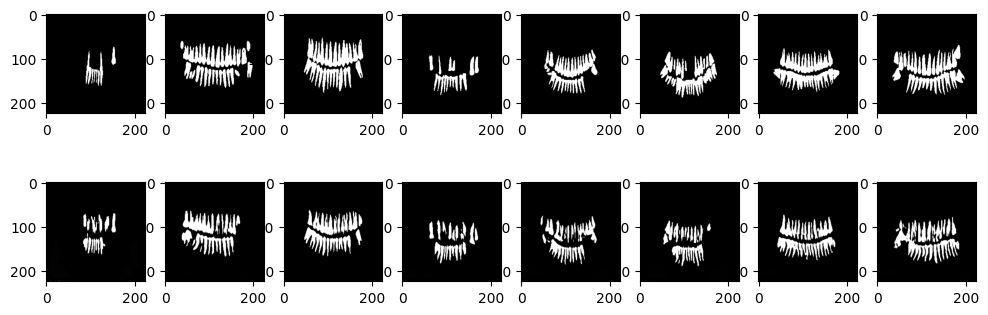

Epoch/Epochs: 700/7000
discriminator loss: [tag: 0.22314193844795227,], generator loss: [tag: 0.24124571681022644,]
1/1 [==============================] - 0s 25ms/step


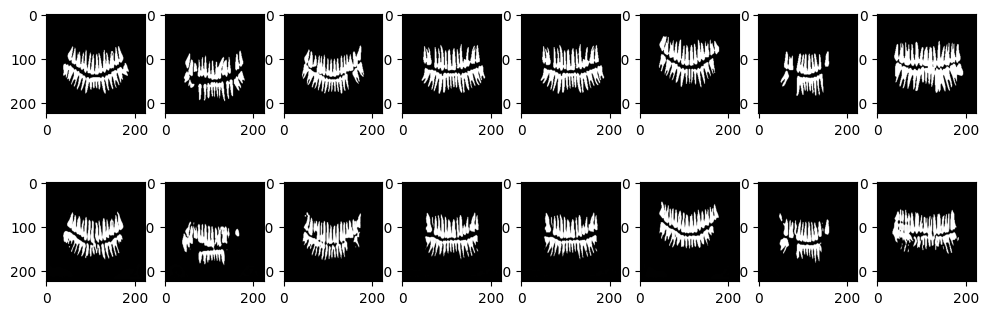

Epoch/Epochs: 750/7000
discriminator loss: [tag: 0.22659575939178467,], generator loss: [tag: 0.29407304525375366,]
1/1 [==============================] - 0s 25ms/step


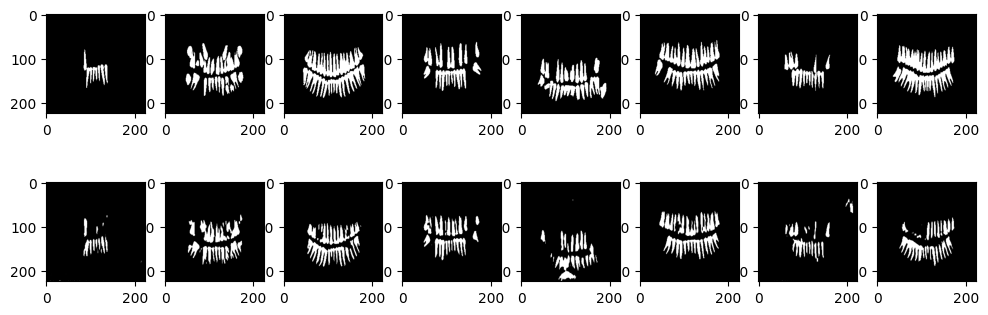

Epoch/Epochs: 800/7000
discriminator loss: [tag: 0.23792219161987305,], generator loss: [tag: 0.33628302812576294,]
1/1 [==============================] - 0s 25ms/step


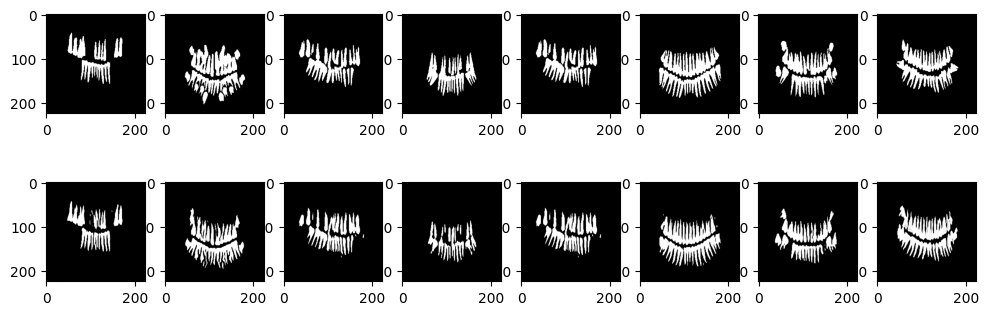

Epoch/Epochs: 850/7000
discriminator loss: [tag: 0.22095467150211334,], generator loss: [tag: 0.23667556047439575,]
1/1 [==============================] - 0s 25ms/step


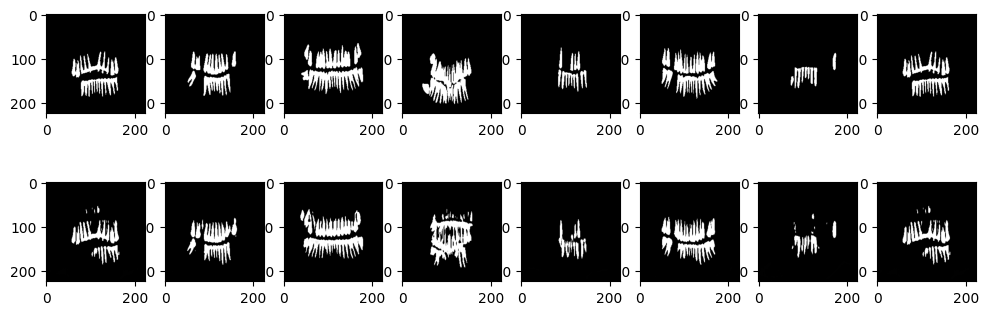

Epoch/Epochs: 900/7000
discriminator loss: [tag: 0.24422088265419006,], generator loss: [tag: 0.2924993634223938,]
1/1 [==============================] - 0s 39ms/step


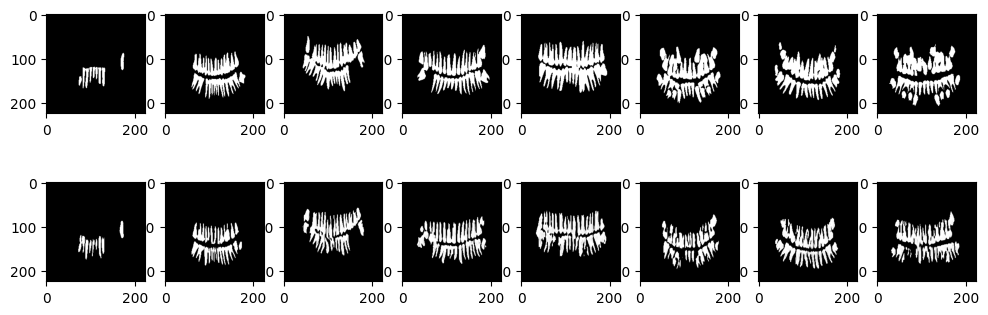

Epoch/Epochs: 950/7000
discriminator loss: [tag: 0.25835779309272766,], generator loss: [tag: 0.21524342894554138,]
1/1 [==============================] - 0s 45ms/step


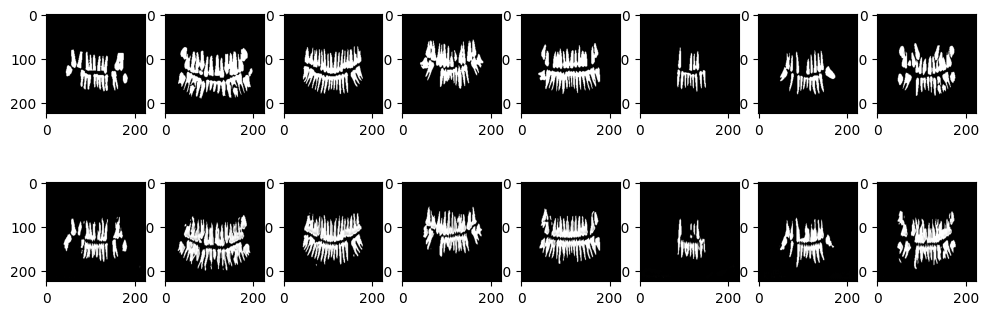

Epoch/Epochs: 1000/7000
discriminator loss: [tag: 0.24977551400661469,], generator loss: [tag: 0.24179773032665253,]
1/1 [==============================] - 0s 26ms/step


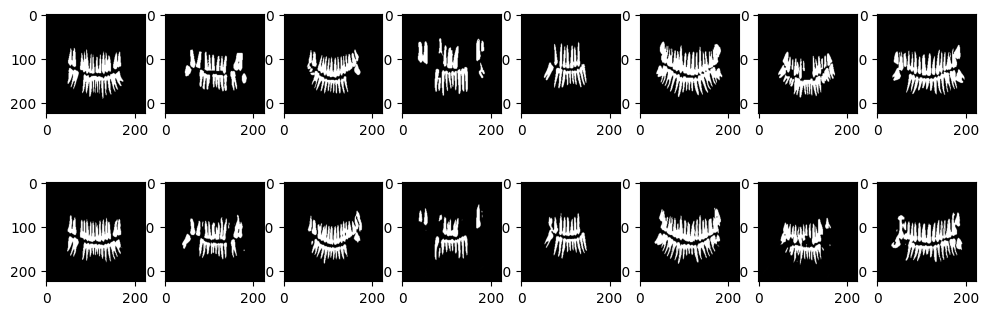

Epoch/Epochs: 1050/7000
discriminator loss: [tag: 0.2535504698753357,], generator loss: [tag: 0.2244352102279663,]
1/1 [==============================] - 0s 27ms/step


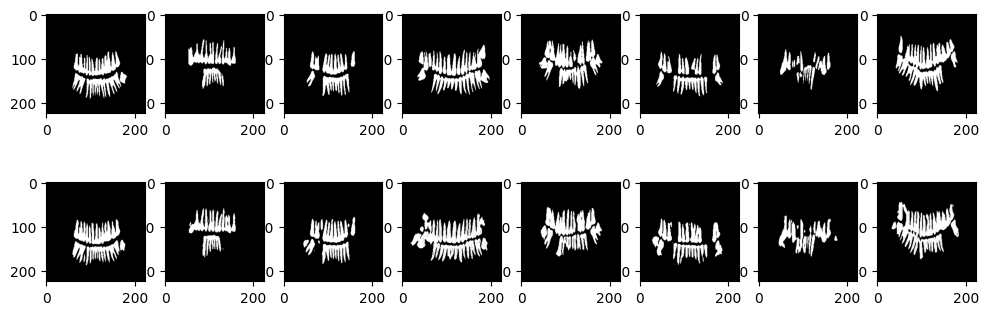

Epoch/Epochs: 1100/7000
discriminator loss: [tag: 0.23807993531227112,], generator loss: [tag: 0.36803311109542847,]
1/1 [==============================] - 0s 43ms/step


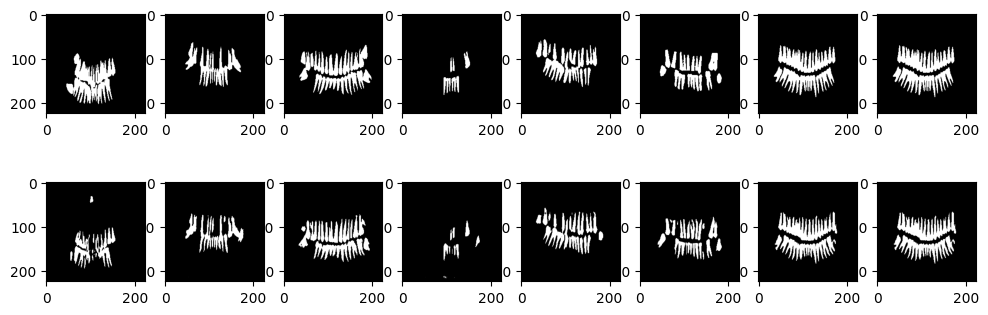

Epoch/Epochs: 1150/7000
discriminator loss: [tag: 0.2152172029018402,], generator loss: [tag: 0.3615894913673401,]
1/1 [==============================] - 0s 39ms/step


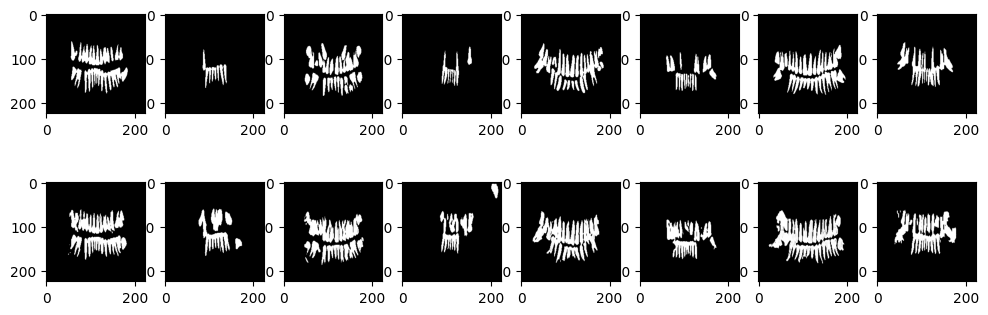

Epoch/Epochs: 1200/7000
discriminator loss: [tag: 0.22511711716651917,], generator loss: [tag: 0.2408817857503891,]
1/1 [==============================] - 0s 26ms/step


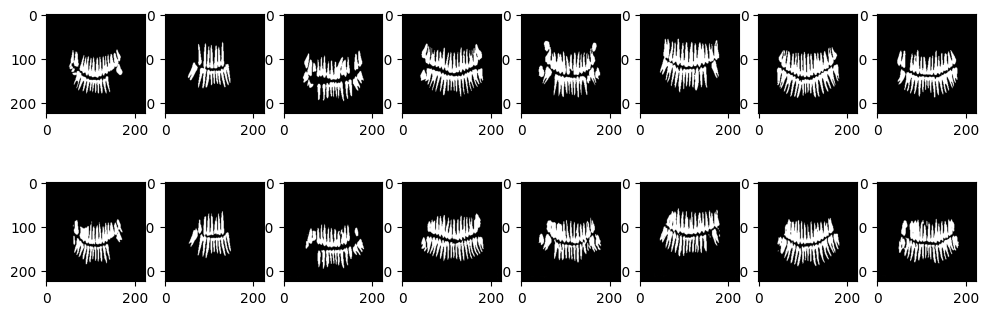

Epoch/Epochs: 1250/7000
discriminator loss: [tag: 0.2997319996356964,], generator loss: [tag: 0.10856865346431732,]
1/1 [==============================] - 0s 24ms/step


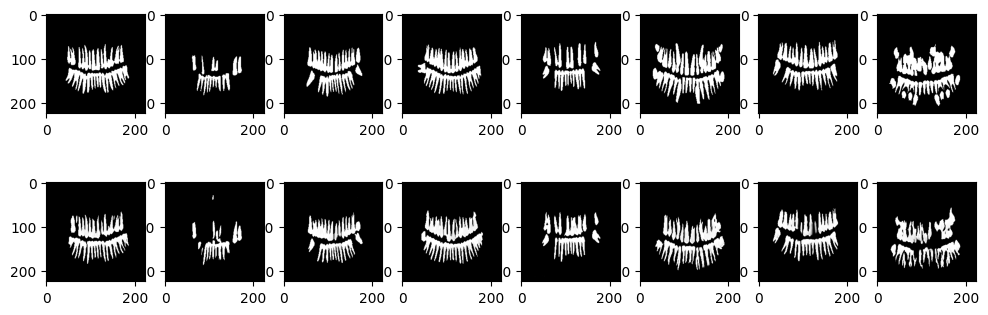

Epoch/Epochs: 1300/7000
discriminator loss: [tag: 0.2523219585418701,], generator loss: [tag: 0.20996621251106262,]
1/1 [==============================] - 0s 44ms/step


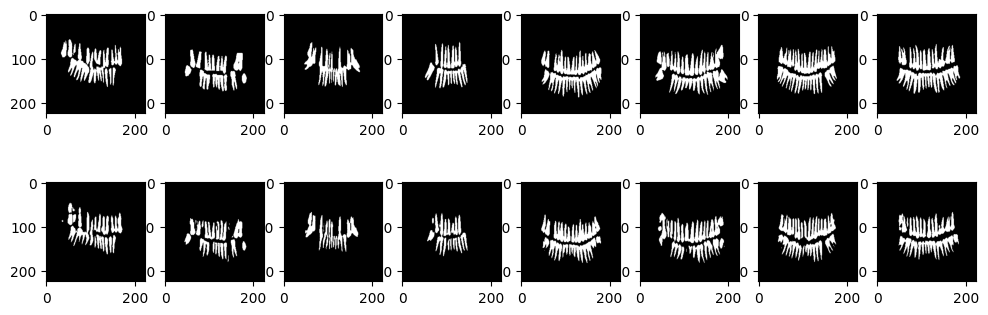

Epoch/Epochs: 1350/7000
discriminator loss: [tag: 0.2261001616716385,], generator loss: [tag: 0.36173197627067566,]
1/1 [==============================] - 0s 26ms/step


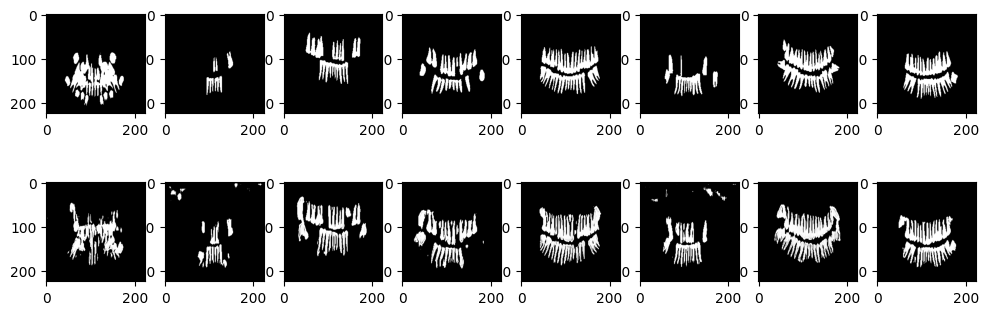

Epoch/Epochs: 1400/7000
discriminator loss: [tag: 0.22286689281463623,], generator loss: [tag: 0.3684620261192322,]
1/1 [==============================] - 0s 26ms/step


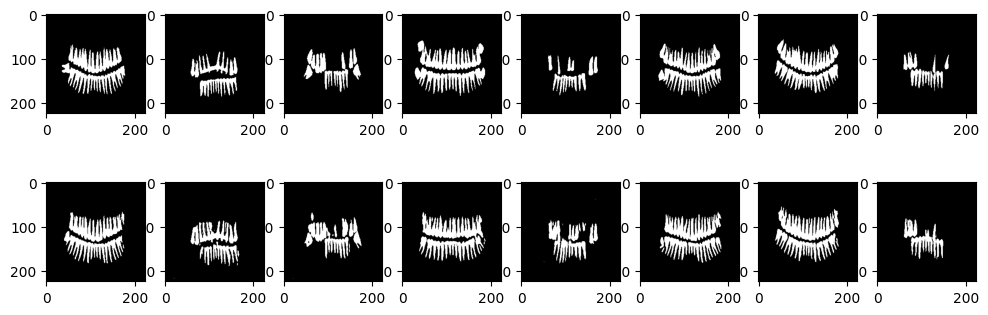

Epoch/Epochs: 1450/7000
discriminator loss: [tag: 0.22680124640464783,], generator loss: [tag: 0.21689504384994507,]
1/1 [==============================] - 0s 26ms/step


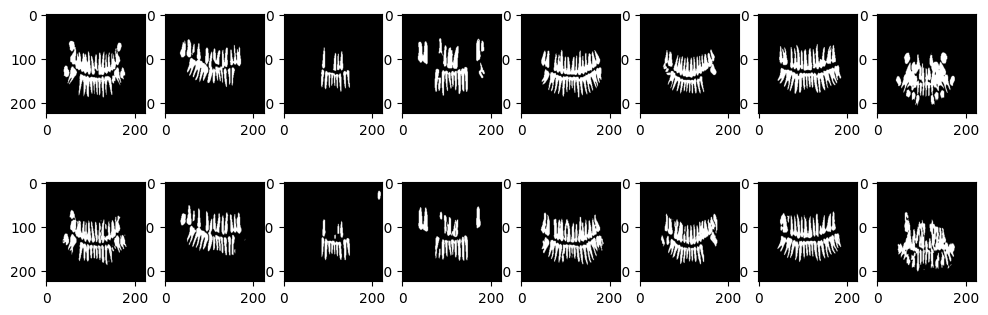

Epoch/Epochs: 1500/7000
discriminator loss: [tag: 0.23974917829036713,], generator loss: [tag: 0.2551659345626831,]
1/1 [==============================] - 0s 24ms/step


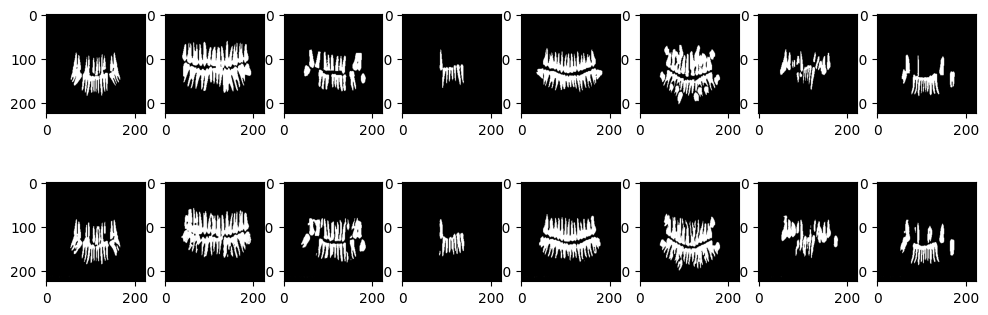

Epoch/Epochs: 1550/7000
discriminator loss: [tag: 0.2116105854511261,], generator loss: [tag: 0.29102519154548645,]
1/1 [==============================] - 0s 25ms/step


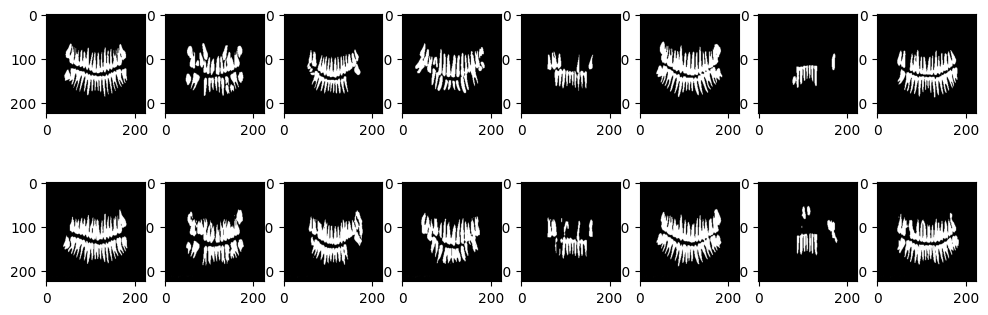

Epoch/Epochs: 1600/7000
discriminator loss: [tag: 0.24528540670871735,], generator loss: [tag: 0.18084116280078888,]
1/1 [==============================] - 0s 25ms/step


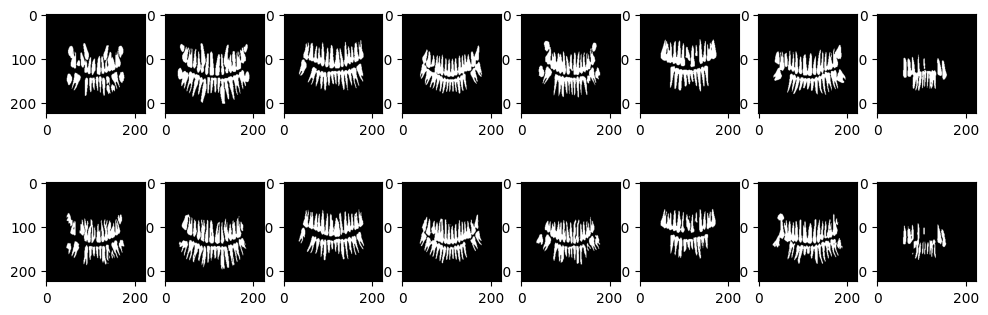

Epoch/Epochs: 1650/7000
discriminator loss: [tag: 0.22995232045650482,], generator loss: [tag: 0.2456459105014801,]
1/1 [==============================] - 0s 37ms/step


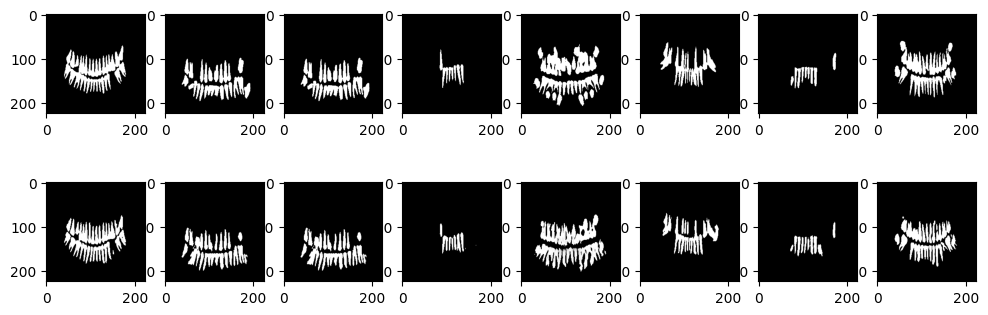

Epoch/Epochs: 1700/7000
discriminator loss: [tag: 0.25334131717681885,], generator loss: [tag: 0.1780373752117157,]
1/1 [==============================] - 0s 26ms/step


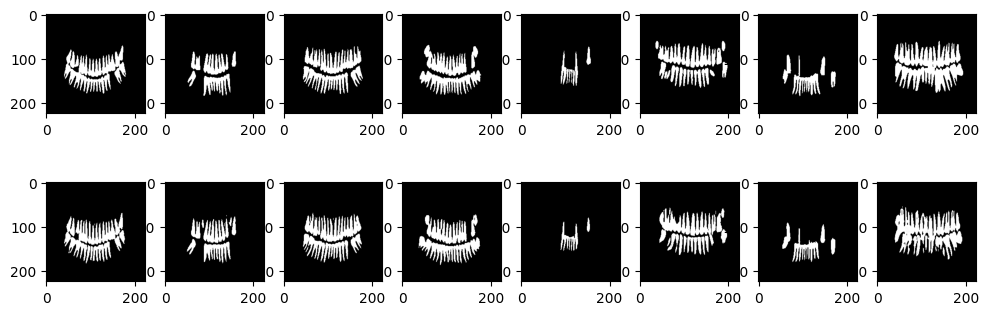

Epoch/Epochs: 1750/7000
discriminator loss: [tag: 0.22069087624549866,], generator loss: [tag: 0.3018611669540405,]
1/1 [==============================] - 0s 29ms/step


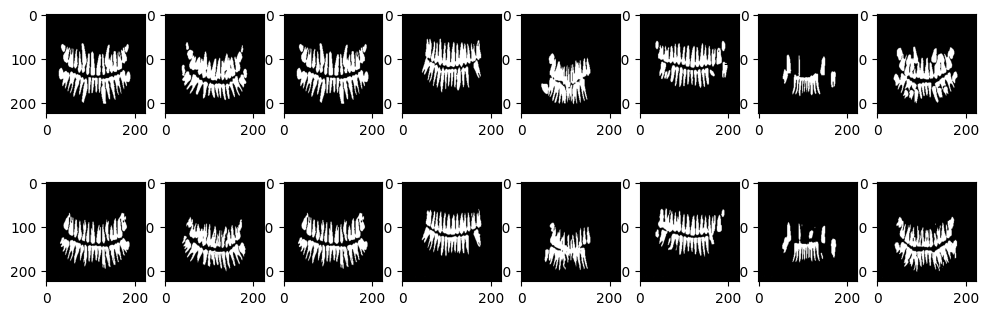

Epoch/Epochs: 1800/7000
discriminator loss: [tag: 0.2476082444190979,], generator loss: [tag: 0.33791738748550415,]
1/1 [==============================] - 0s 36ms/step


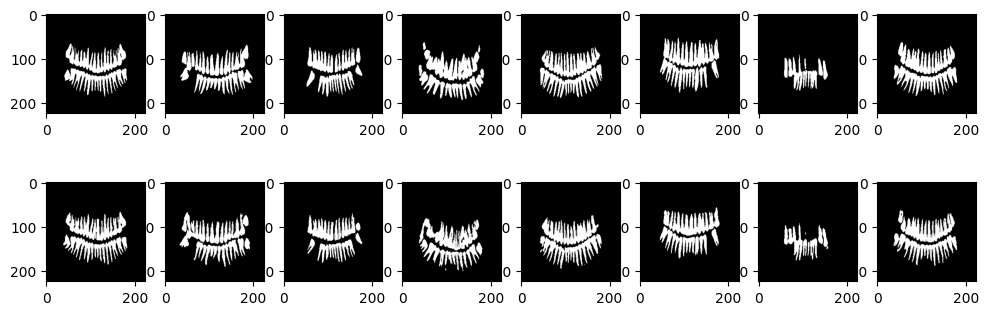

Epoch/Epochs: 1850/7000
discriminator loss: [tag: 0.21236677467823029,], generator loss: [tag: 0.44099366664886475,]
1/1 [==============================] - 0s 28ms/step


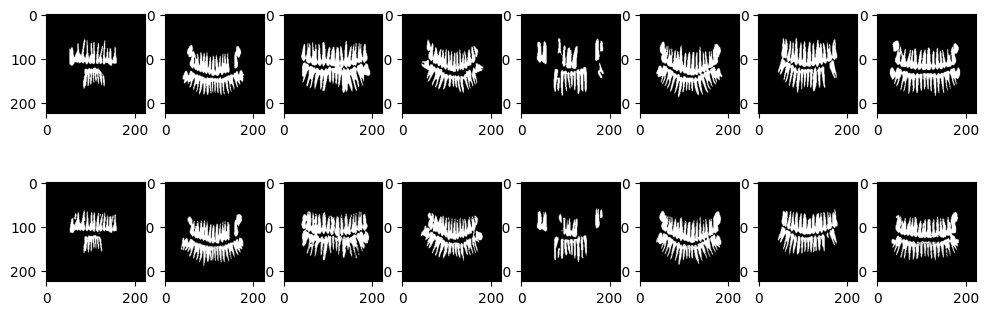

Epoch/Epochs: 1900/7000
discriminator loss: [tag: 0.2342987358570099,], generator loss: [tag: 0.2116820365190506,]
1/1 [==============================] - 0s 29ms/step


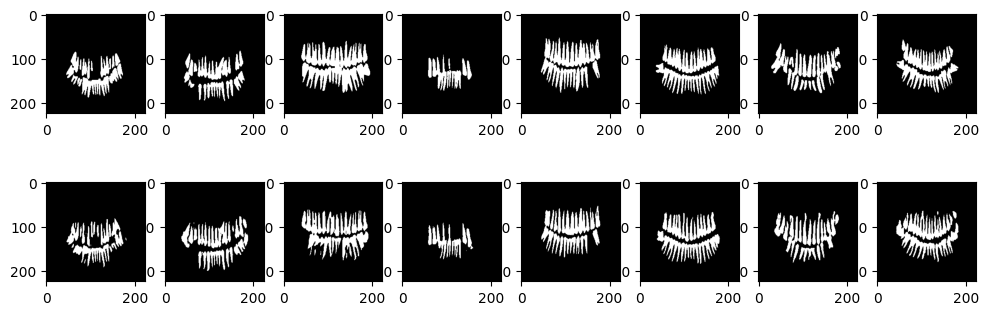

Epoch/Epochs: 1950/7000
discriminator loss: [tag: 0.22908245027065277,], generator loss: [tag: 0.3377722501754761,]
1/1 [==============================] - 0s 48ms/step


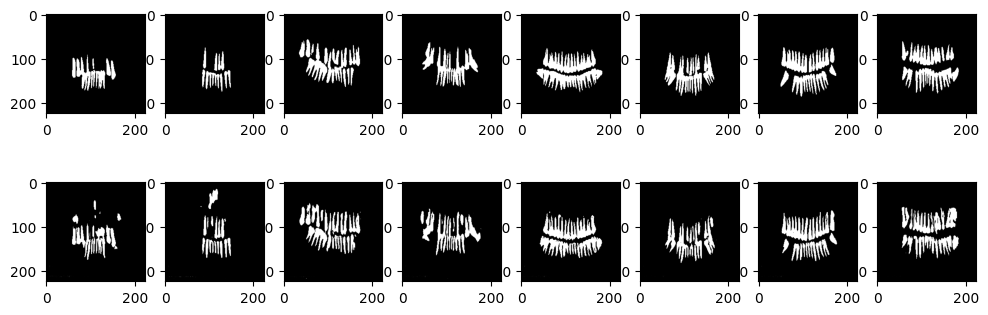

Epoch/Epochs: 2000/7000
discriminator loss: [tag: 0.23024803400039673,], generator loss: [tag: 0.2125689536333084,]
1/1 [==============================] - 0s 28ms/step


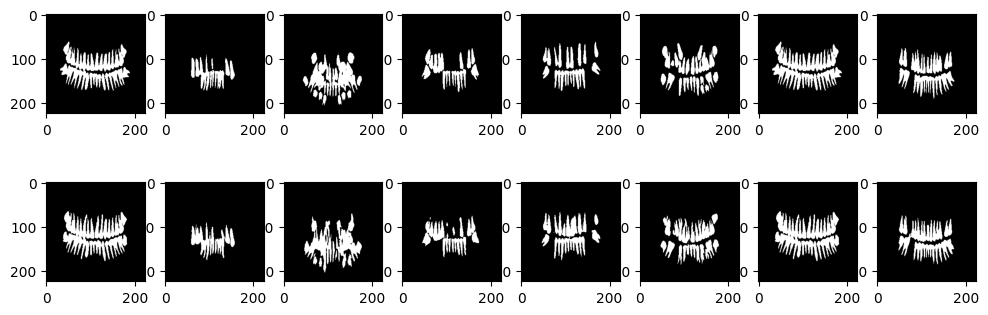

Epoch/Epochs: 2050/7000
discriminator loss: [tag: 0.24633458256721497,], generator loss: [tag: 0.4403989315032959,]
1/1 [==============================] - 0s 27ms/step


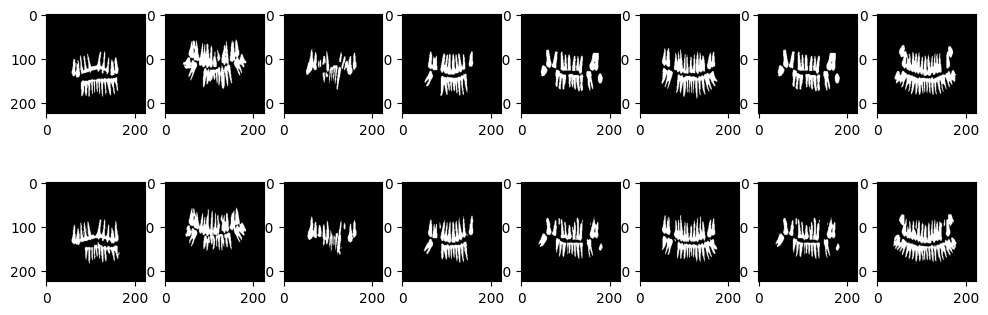

Epoch/Epochs: 2100/7000
discriminator loss: [tag: 0.23349466919898987,], generator loss: [tag: 0.4462570250034332,]
1/1 [==============================] - 0s 25ms/step


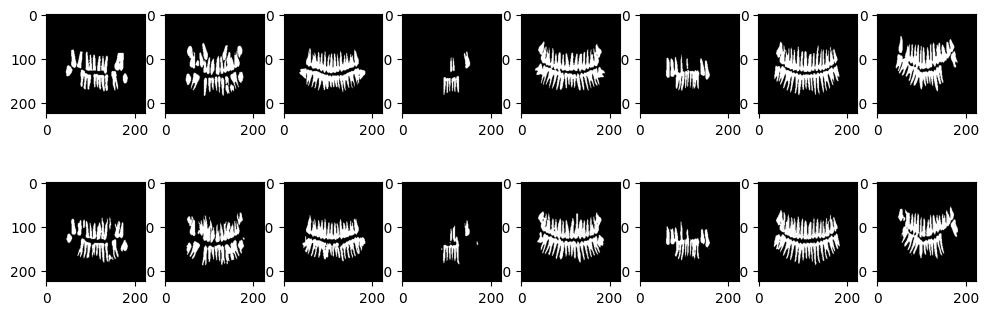

Epoch/Epochs: 2150/7000
discriminator loss: [tag: 0.3711157739162445,], generator loss: [tag: 0.168584406375885,]
1/1 [==============================] - 0s 35ms/step


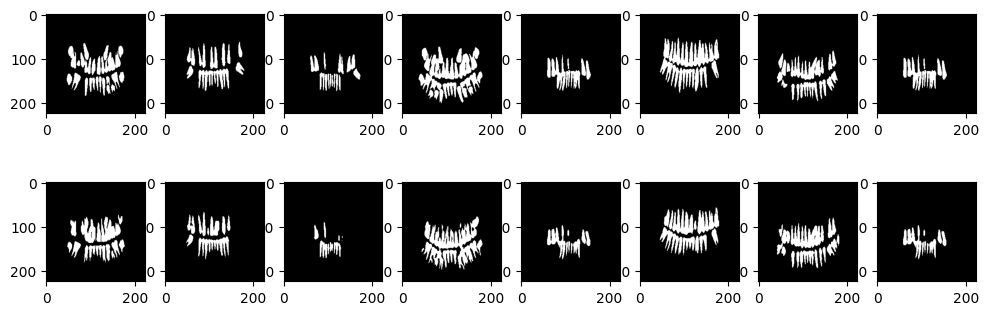

Epoch/Epochs: 2200/7000
discriminator loss: [tag: 0.23779892921447754,], generator loss: [tag: 0.17192842066287994,]
1/1 [==============================] - 0s 26ms/step


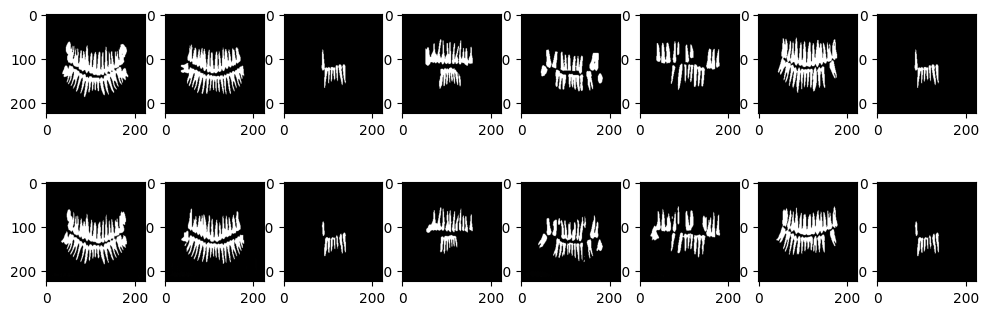

Epoch/Epochs: 2250/7000
discriminator loss: [tag: 0.2320585548877716,], generator loss: [tag: 0.23059317469596863,]
1/1 [==============================] - 0s 25ms/step


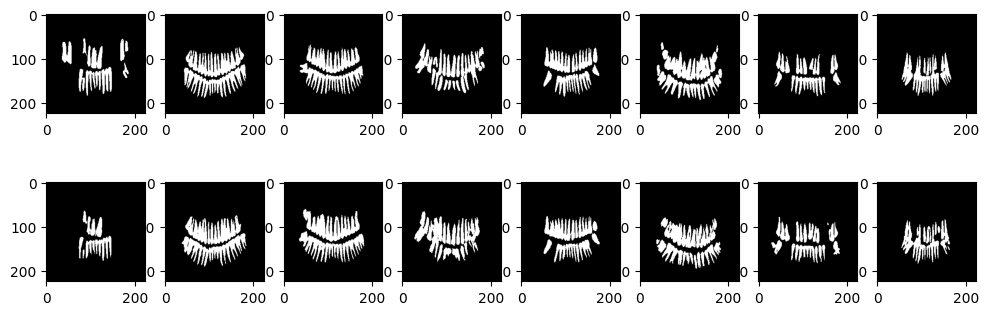

Epoch/Epochs: 2300/7000
discriminator loss: [tag: 0.27537745237350464,], generator loss: [tag: 0.1475442796945572,]
1/1 [==============================] - 0s 41ms/step


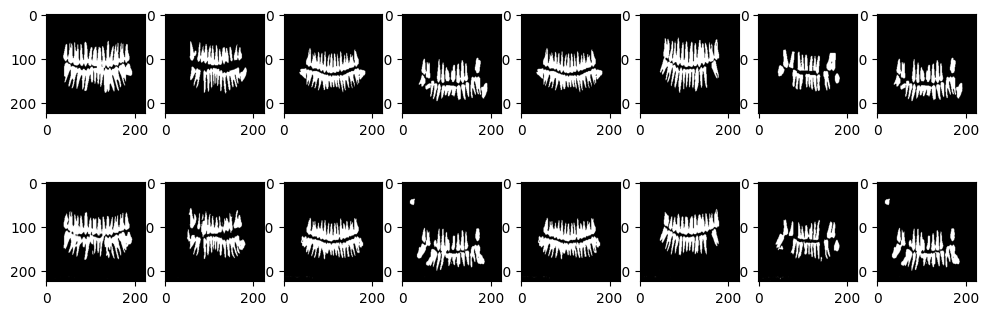

Epoch/Epochs: 2350/7000
discriminator loss: [tag: 0.13991181552410126,], generator loss: [tag: 0.8536989688873291,]
1/1 [==============================] - 0s 26ms/step


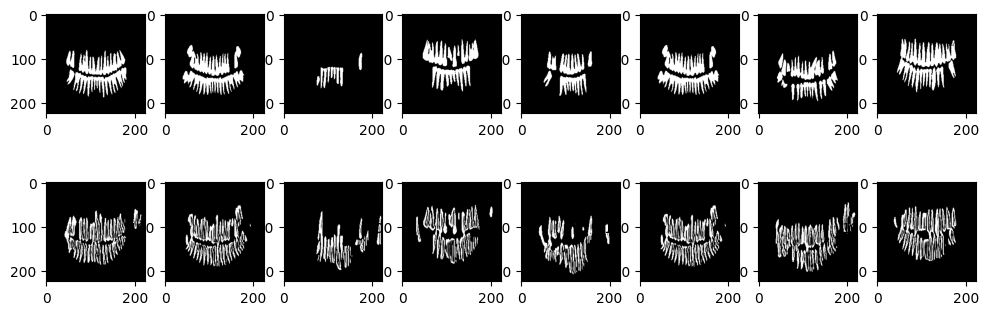

Epoch/Epochs: 2400/7000
discriminator loss: [tag: 0.24226582050323486,], generator loss: [tag: 0.2902216911315918,]
1/1 [==============================] - 0s 25ms/step


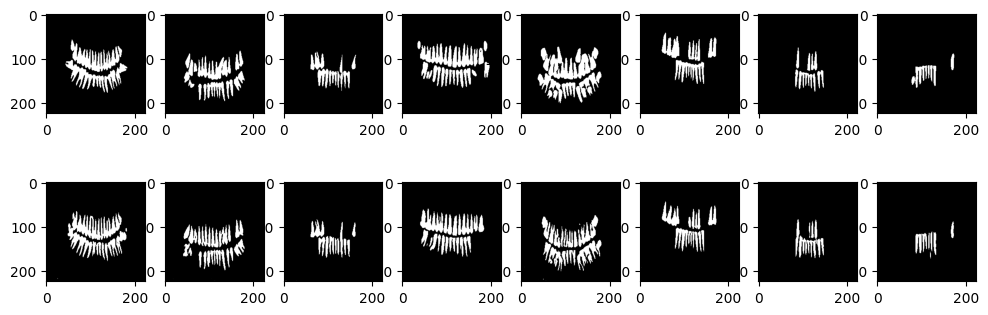

Epoch/Epochs: 2450/7000
discriminator loss: [tag: 0.2175006866455078,], generator loss: [tag: 0.5033633708953857,]
1/1 [==============================] - 0s 27ms/step


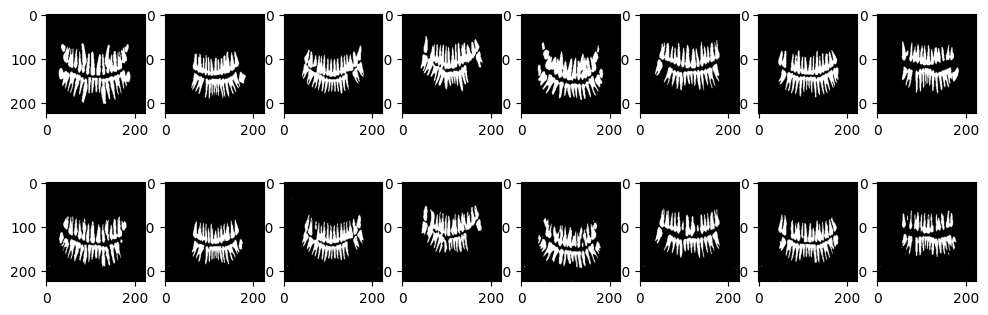

Epoch/Epochs: 2500/7000
discriminator loss: [tag: 0.23025526106357574,], generator loss: [tag: 0.4353982210159302,]
1/1 [==============================] - 0s 25ms/step


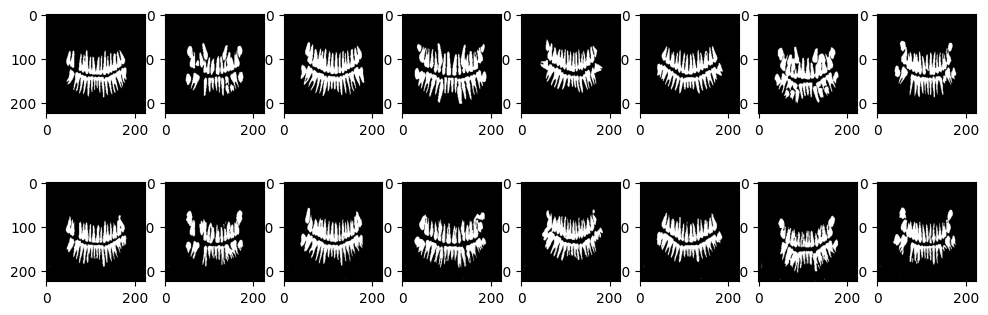

Epoch/Epochs: 2550/7000
discriminator loss: [tag: 0.21116797626018524,], generator loss: [tag: 0.41743040084838867,]
1/1 [==============================] - 0s 28ms/step


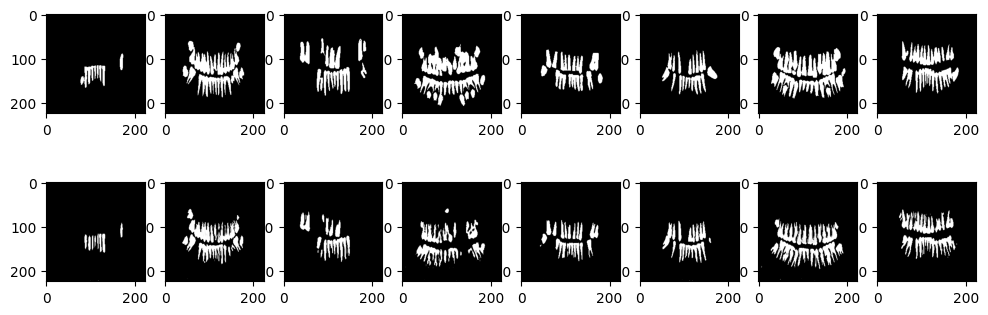

Epoch/Epochs: 2600/7000
discriminator loss: [tag: 0.22383087873458862,], generator loss: [tag: 0.20778381824493408,]
1/1 [==============================] - 0s 25ms/step


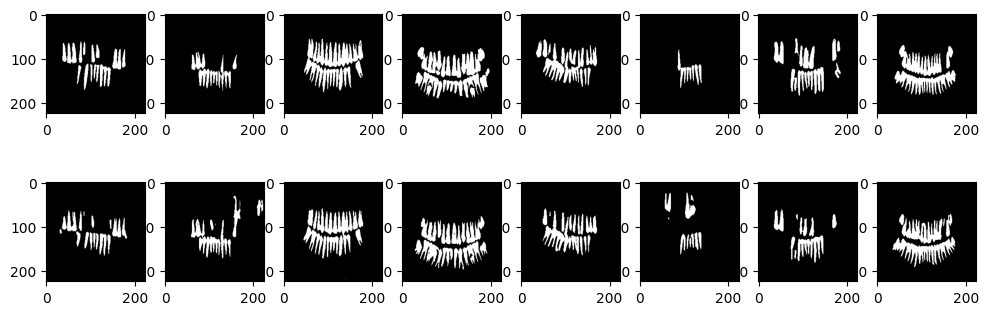

Epoch/Epochs: 2650/7000
discriminator loss: [tag: 0.2510305345058441,], generator loss: [tag: 0.16541439294815063,]
1/1 [==============================] - 0s 25ms/step


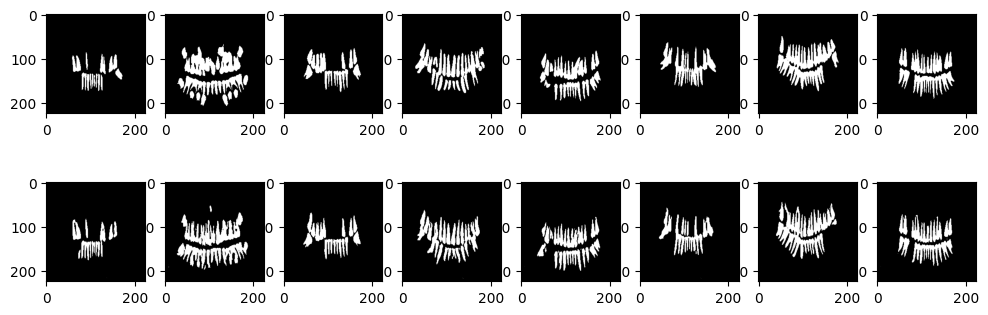

Epoch/Epochs: 2700/7000
discriminator loss: [tag: 0.2521692216396332,], generator loss: [tag: 0.1153995618224144,]
1/1 [==============================] - 0s 25ms/step


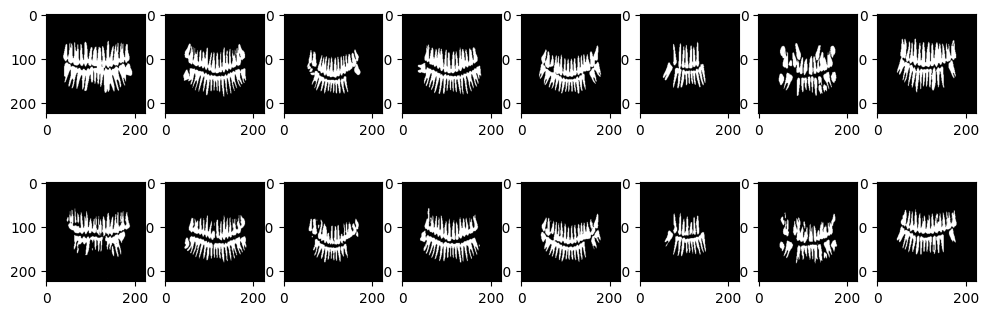

Epoch/Epochs: 2750/7000
discriminator loss: [tag: 0.20825043320655823,], generator loss: [tag: 0.46760493516921997,]
1/1 [==============================] - 0s 24ms/step


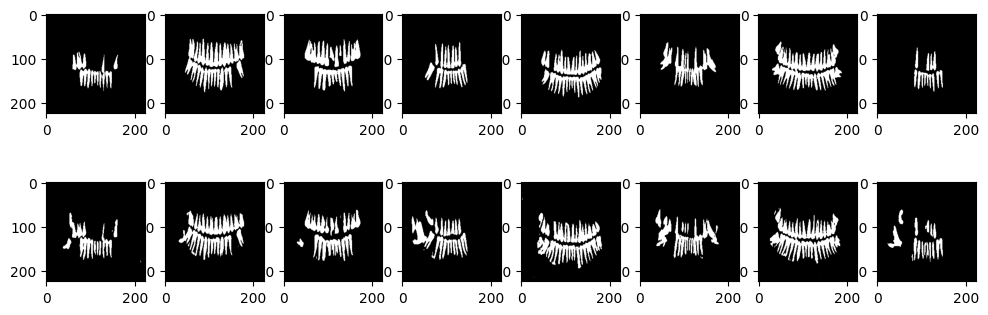

Epoch/Epochs: 2800/7000
discriminator loss: [tag: 0.19566261768341064,], generator loss: [tag: 0.32577577233314514,]
1/1 [==============================] - 0s 26ms/step


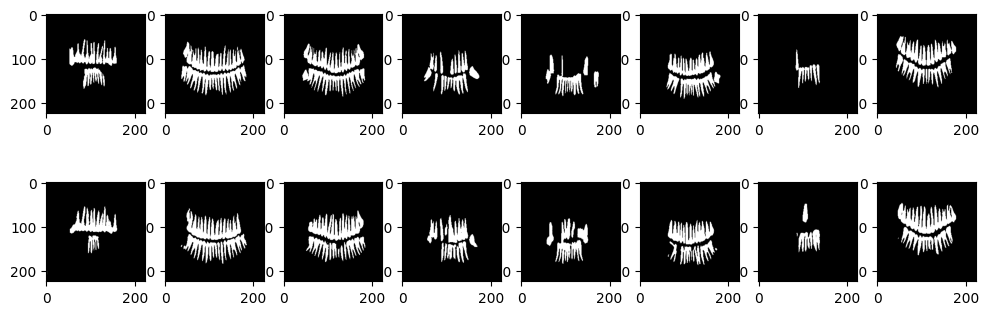

Epoch/Epochs: 2850/7000
discriminator loss: [tag: 0.26236099004745483,], generator loss: [tag: 0.5558732748031616,]
1/1 [==============================] - 0s 27ms/step


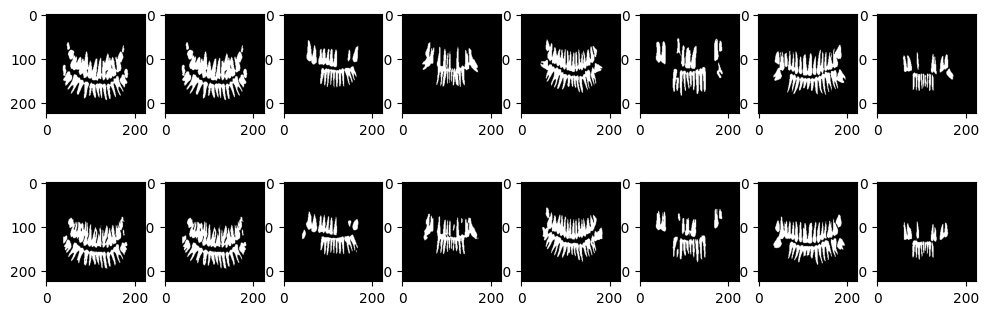

Epoch/Epochs: 2900/7000
discriminator loss: [tag: 0.2331167459487915,], generator loss: [tag: 0.33313482999801636,]
1/1 [==============================] - 0s 38ms/step


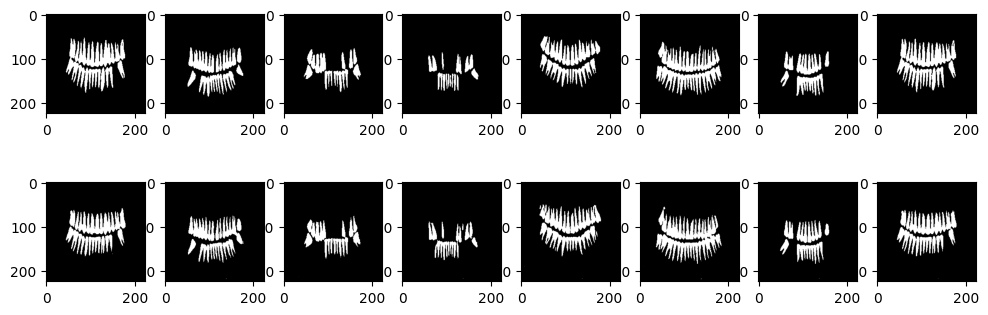

Epoch/Epochs: 2950/7000
discriminator loss: [tag: 0.20921412110328674,], generator loss: [tag: 0.4584423303604126,]
1/1 [==============================] - 0s 36ms/step


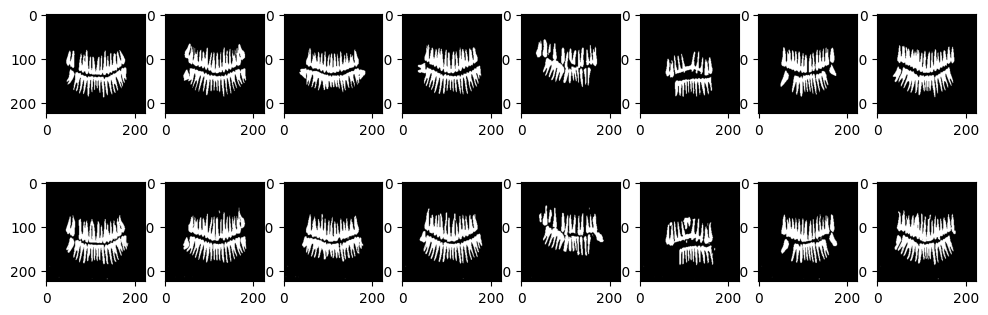

Epoch/Epochs: 3000/7000
discriminator loss: [tag: 0.19952887296676636,], generator loss: [tag: 0.45793259143829346,]
1/1 [==============================] - 0s 25ms/step


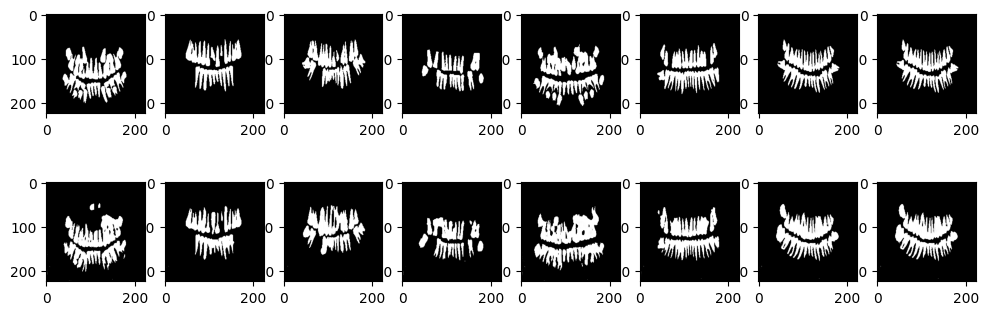

Epoch/Epochs: 3050/7000
discriminator loss: [tag: 0.26141780614852905,], generator loss: [tag: 0.5106028914451599,]
1/1 [==============================] - 0s 28ms/step


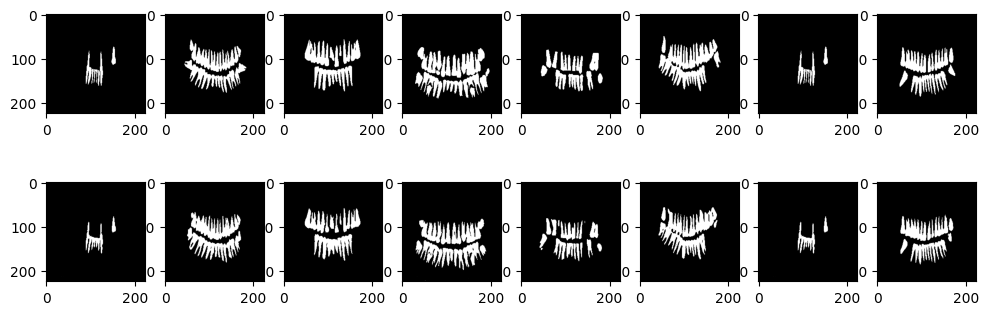

Epoch/Epochs: 3100/7000
discriminator loss: [tag: 0.19110718369483948,], generator loss: [tag: 0.3233868479728699,]
1/1 [==============================] - 0s 25ms/step


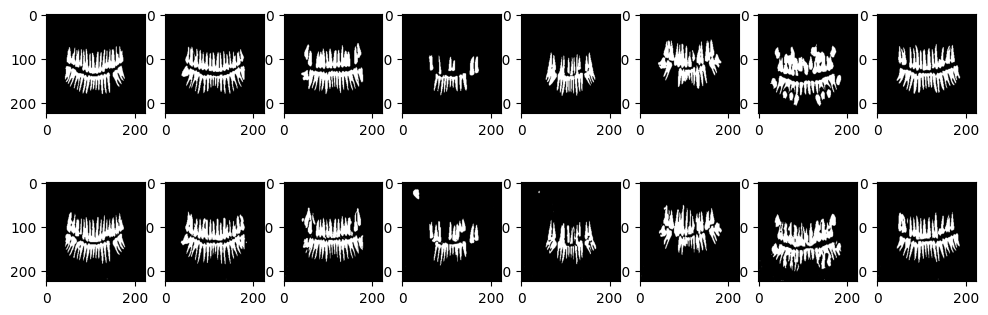

Epoch/Epochs: 3150/7000
discriminator loss: [tag: 0.19450299441814423,], generator loss: [tag: 0.4066213369369507,]
1/1 [==============================] - 0s 25ms/step


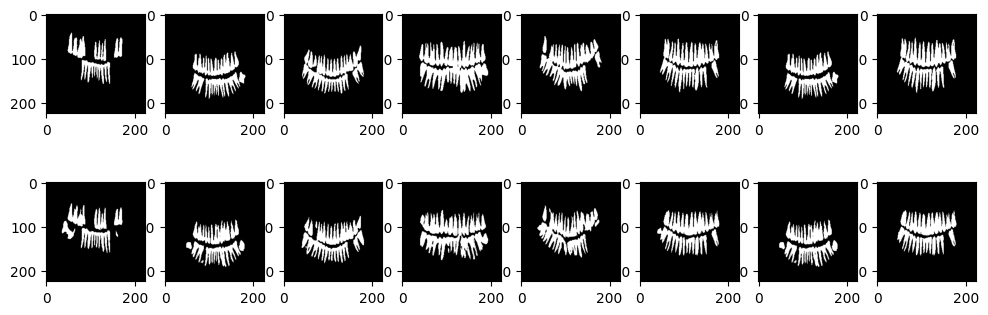

KeyboardInterrupt: 

In [30]:
for epoch in range(epochs):
    indexs = np.random.randint(0, len(trainImages), size = (batch, ))
    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape = (batch, ))
    fakeMasks = tf.squeeze(G.predict([realImages], verbose = 0))
    fakeTag = tf.zeros(shape = (batch, ))
    allMasks = np.vstack([realMasks, fakeMasks])
    allTags = np.hstack([realTag, fakeTag])
    allImages = np.vstack([realImages, realImages])
    dlossTag = D.train_on_batch([allMasks, allImages], [allTags])
    glossTag = gan.train_on_batch([realImages], [realTag,])
    if epoch % 50 == 0:
        print('Epoch/Epochs: {}/{}'.format(epoch, epochs))
        print('discriminator loss: [tag: {},], generator loss: [tag: {},]'.format(dlossTag, glossTag))
        validIndexs = np.random.randint(0, len(validImages), size = (8, ))
        samples(G, validImages[validIndexs], validMasks[validIndexs])
